In [ ]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

import jax

from pulsedjax.simulate_trace import MakeTrace, apply_noise, GaussianAmplitude, PolynomialPhase, MultiPulse, RandomPhase

/home/tillstehling/miniconda3/lib/python3.11/site-packages/refractiveindex/refractiveindex.py:300: RuntimeWarning: invalid value encountered in sqrt
  n = np.sqrt(nsq)


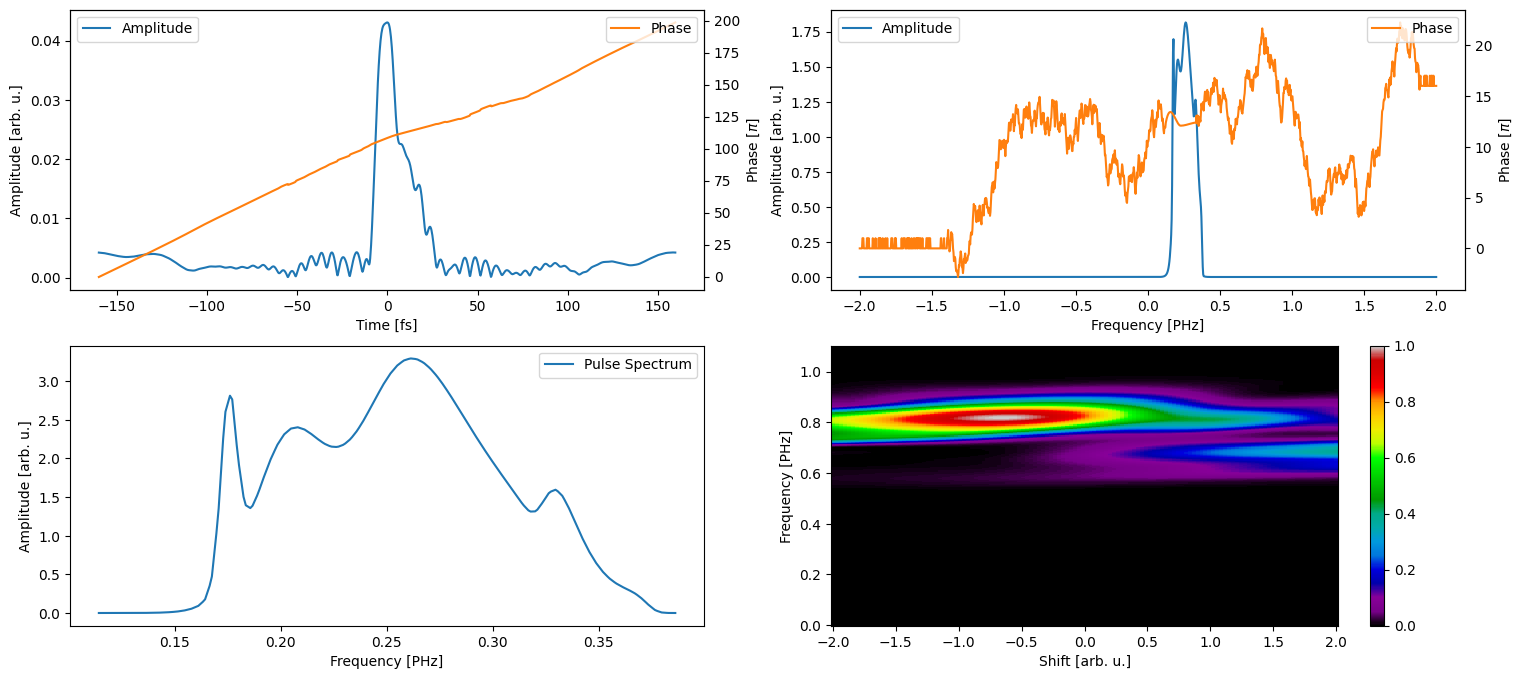

In [ ]:
from pulsedjax.simulate_trace import MakeTrace
from pulsedjax.simulate_trace import GaussianAmplitude, RandomPhase
import jax.numpy as jnp

amp0 = GaussianAmplitude((1,1,1,0.9,0.5), (0.175,0.2,0.25,0.29,0.35), (0.01,0.05,0.1,0.1,0.05), (1,1,1,2,3))
phase0 = RandomPhase(number_of_points=4)


mp = MakeTrace(N=128*10, f_max=2)
time, pulse_t, frequency, pulse_f = mp.generate_pulse((amp0,phase0))


import refractiveindex
parameters = refractiveindex.RefractiveIndexMaterial(shelf="main", book="SiO2", page="Malitson")
z_arr = jnp.linspace(-2,2,128)
z_arr, frequency_trace, trace, spectra = mp.generate_chirpscan(time, frequency, pulse_t, pulse_f, "thg", 
                                                               z_arr, "material", parameters, frequency_range=(0,1.1))


/home/tillstehling/miniconda3/lib/python3.11/site-packages/refractiveindex/refractiveindex.py:297: RuntimeWarning: invalid value encountered in divide
  g = lambda c1, c2, w: c1 * (w ** 2) / (w ** 2 - c2 ** 2)
/home/tillstehling/miniconda3/lib/python3.11/site-packages/refractiveindex/refractiveindex.py:300: RuntimeWarning: invalid value encountered in sqrt
  n = np.sqrt(nsq)


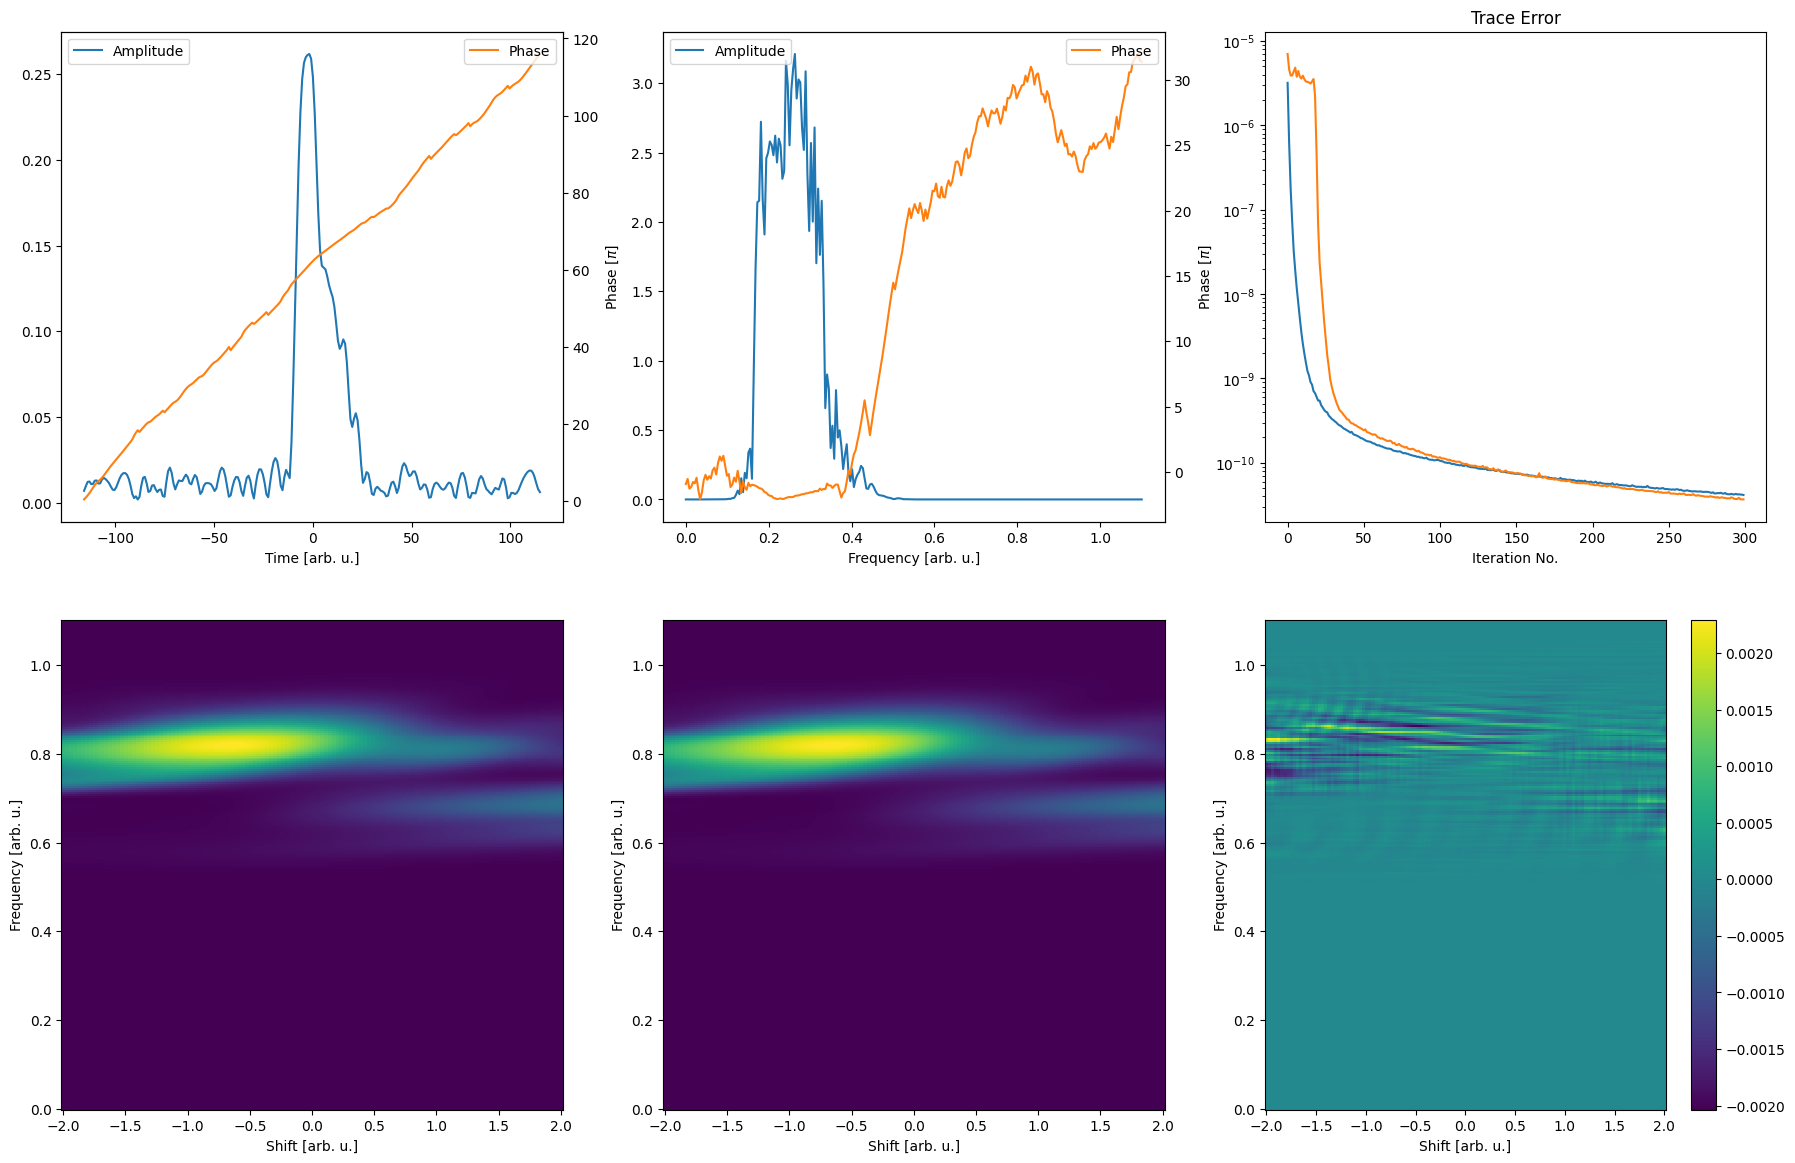

In [ ]:
from pulsedjax.chirp_scan import PtychographicIterativeEngine

copra = PtychographicIterativeEngine(z_arr, frequency_trace, trace, "thg", pie_method="rPIE", phase_type="material", chirp_parameters=parameters)

population = copra.create_initial_population(2, "random")

copra.alpha = 0.1
copra.local_gamma = 0.1
copra.global_gamma = 0.001

final_result = copra.run(population, 300, 0)
copra.plot_results(final_result)